<a href="https://colab.research.google.com/github/zainabintech/DDoS-Detection-System-/blob/main/Copy_of_FFfinal_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phase 1: Data Preprocessing

### Overview

This section prepares the CICIDS2019 dataset for modeling by loading data in chunks, cleaning, encoding categorical variables, handling missing values, balancing classes with SMOTE, and scaling features. Visualizations inspect data quality and justify preprocessing steps.

**Technical Aspects**:
- **Chunk-based Loading**: Uses `pandas.read_csv` with `chunksize=100000` to manage memory efficiently.
- **LabelEncoder**: Converts `Label` (e.g., "LDAP", "Benign") and `SimillarHTTP` to numerical values.
- **SMOTE**: Generates synthetic samples for minority classes (e.g., rare attacks like NetBIOS).
- **StandardScaler**: Normalizes features to zero mean and unit variance, which is critical for algorithms like SVM and KNN.
- **Timestamp Features**: Extracts `Hour`, `Minute`, etc., to capture temporal attack patterns.
- **Graphs**: Includes missing value heatmap, class distribution, correlation matrix, feature distributions, and feature variance.


### 1.1 Import Required Libraries

**Purpose**:  
Import essential Python libraries for data manipulation, preprocessing, and visualization to support the analysis of the DDoS2017CIC dataset.

---

###  Technical Justification

- **`pandas` and `numpy`**:  
  These libraries are foundational for handling large datasets and performing numerical computations. This is critical for processing the voluminous network traffic data in the DDoS2017CIC dataset.

- **`matplotlib` and `seaborn`**:  
  These enable visualization of data distributions and patterns, which is vital for exploratory data analysis. In a research setting, this helps in understanding the characteristics of different types of attacks.

- **`LabelEncoder` and `StandardScaler`** *(from `sklearn.preprocessing`)*:  
  Used for encoding categorical variables (e.g., `Label`) and normalizing numeric features, respectively. These are standard preprocessing steps for preparing network datasets for machine learning.

- **`SMOTE`** *(from `imblearn.over_sampling`)*:  
  Addresses class imbalance — a common challenge in intrusion detection datasets like DDoS2017CIC — where benign traffic often vastly outnumbers attack instances.

- **`Counter`** *(from `collections`)*:  
  Aids in analyzing class distributions, helping ensure that the research accounts for imbalance effectively during preprocessing and model evaluation.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

### 1.2 Load and Sample Data

**Purpose**:  
Load CICIDS2019 CSV files in chunks, sample rows to reduce memory usage, and combine into a single DataFrame for analysis.

---

###  Steps

1. **Mount Google Drive** to access dataset files stored at `/content/drive/MyDrive/data/`.
2. **Define a list of CSV files** corresponding to different attack types (e.g., `LDAP`, `MSSQL`, `NetBIOS`, `Portmap`, `Syn`, `UDP`, `UDPLag`).
3. **Read each CSV in chunks** of 100,000 rows, sampling up to 5,000 rows per chunk using `random_state=42` for reproducibility.
4. **Combine sampled chunks** into a single DataFrame.
5. **Display dataset metadata** including shape, feature names, and data types.

---

###  Technical Justification

- **Chunk-Based Loading**:  
  Files like `UDP.csv` can exceed 1 GB, potentially causing memory crashes. Loading data in chunks of 100,000 rows ensures efficient memory usage on standard hardware.

- **Random Sampling**:  
  Sampling 5,000 rows per chunk manages the dataset's scale while maintaining representative data. Using `random_state=42` ensures reproducible sampling during repeated runs.

- **Google Drive Integration**:  
  Storing data on Google Drive is practical in cloud-based environments like Google Colab, enabling convenient access to large datasets.

- **Feature Inspection**:  
  Displaying feature names and data types assists in identifying potential data issues (e.g., `object`-type columns such as `SimillarHTTP`), and confirms the dataset structure (88 features).


In [ ]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

# List of CSV files to read (update the paths to match your Google Drive structure)
csv_files = [
    '/content/drive/MyDrive/data/LDAP.csv',
    '/content/drive/MyDrive/data/MSSQL.csv',
    '/content/drive/MyDrive/data/NetBIOS.csv',
    '/content/drive/MyDrive/data/Portmap.csv',
    '/content/drive/MyDrive/data/Syn.csv',
    '/content/drive/MyDrive/data/UDP.csv',
    '/content/drive/MyDrive/data/UDPLag.csv',
]

# Read and sample from each CSV using chunks
dfs = []
chunk_size = 100000  # Rows per chunk

for file in csv_files:
    try:
        print(f"Reading from {file} ...")
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue

        chunk_reader = pd.read_csv(file, chunksize=chunk_size, low_memory=False)
        for chunk in chunk_reader:
            sampled_chunk = chunk.sample(min(5000, len(chunk)), random_state=42)
            dfs.append(sampled_chunk)
        print(f"Finished processing: {file}")
    except Exception as e:
        print(f"Error in {file}: {e}")

# Combine and save
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"Combined dataset shape: {df.shape}")

    print("\nFeature (column) names and data types:")
    for col in df.columns:
        print(f"- {col}: {df[col].dtype}")

    print(f"\nTotal number of features: {len(df.columns)}")

    #  Save the DataFrame to CSV
    output_path = '/content/drive/MyDrive/data/combined_sampled_ddos.csv'
    df.to_csv(output_path, index=False)
    print(f"\nSampled dataset saved to: {output_path}")

else:
    print("No data was loaded. Please check your file paths.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading from /content/drive/MyDrive/data/LDAP.csv ...
Finished processing: /content/drive/MyDrive/data/LDAP.csv
Reading from /content/drive/MyDrive/data/MSSQL.csv ...
Finished processing: /content/drive/MyDrive/data/MSSQL.csv
Reading from /content/drive/MyDrive/data/NetBIOS.csv ...
Finished processing: /content/drive/MyDrive/data/NetBIOS.csv
Reading from /content/drive/MyDrive/data/Portmap.csv ...
Finished processing: /content/drive/MyDrive/data/Portmap.csv
Reading from /content/drive/MyDrive/data/Syn.csv ...
Finished processing: /content/drive/MyDrive/data/Syn.csv
Reading from /content/drive/MyDrive/data/UDP.csv ...
Finished processing: /content/drive/MyDrive/data/UDP.csv
Reading from /content/drive/MyDrive/data/UDPLag.csv ...
Finished processing: /content/drive/MyDrive/data/UDPLag.csv
Combined dataset shape: (1035000, 88)

Feature (column) names and data ty

In [22]:
df = pd.read_csv('/content/drive/MyDrive/data/combined_sampled_ddos.csv')


### 1.3 Clean Column Names and Handle Categorical Encoding

**Purpose**:  
Standardize column names and encode categorical variables to prepare the CICIDS2019 dataset for machine learning.

---

### Steps

1. Remove leading/trailing spaces from column names.
2. Convert the `SimillarHTTP` column to string type for encoding.
3. Use `LabelEncoder` to transform `SimillarHTTP` and `Label` columns into numeric format.
4. Attempt to convert `Timestamp` to datetime and extract temporal features:
   - Hour
   - Minute
   - Second
   - Day
   - Weekday
5. Drop unnecessary identifier columns:
   - `Source IP`
   - `Destination IP`
   - `Flow ID`
   - `Unnamed: 0`
6. Save the cleaned dataset to Google Drive.
7. Display the first five rows and final shape of the processed DataFrame.

---

### Technical Justification

- **Column Name Cleaning**:  
  The CICIDS2019 dataset may contain inconsistent column names (e.g., leading spaces), which can cause errors during processing. Cleaning ensures compatibility with pandas and scikit-learn functions.

- **Categorical Encoding**:  
  Machine learning models require numeric inputs. `LabelEncoder` converts categorical columns such as `Label` (attack types) and `SimillarHTTP` (HTTP similarity flags) into integers. This preserves essential information while enabling model training.

- **Timestamp Handling**:  
  Extracting features like hour and weekday from timestamps can uncover time-based attack patterns, which are useful for modeling. The code includes error handling to gracefully manage missing or malformed timestamps.

- **Dropping Identifiers**:  
  Columns such as `Source IP`, `Destination IP`, and `Flow ID` are unique identifiers that do not generalize well and may lead to overfitting. Removing them aligns with best practices for training generalizable intrusion detection models.

- **Data Persistence**:  
  Saving the cleaned dataset to Google Drive ensures reproducibility and prevents the need to repeat preprocessing steps, which can be computationally expensive.

- **Error Handling**:  
  The code checks for column presence and uses `errors='ignore'` when dropping columns, which enhances robustness against inconsistencies across different CSV files.


In [23]:
from sklearn.preprocessing import LabelEncoder

# Strip leading/trailing spaces from all column names
df.columns = df.columns.str.strip()

# Convert 'SimillarHTTP' to string (if it exists) for encoding
if 'SimillarHTTP' in df.columns:
    df['SimillarHTTP'] = df['SimillarHTTP'].astype(str)

# Initialize label encoder
le = LabelEncoder()

# Encode 'SimillarHTTP' and 'Label' if present
if 'SimillarHTTP' in df.columns:
    df['SimillarHTTP'] = le.fit_transform(df['SimillarHTTP'])

if 'Label' in df.columns:
    df['Label'] = le.fit_transform(df['Label'])
else:
    print(" 'Label' column not found in dataset!")


    # Convert Timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Extract useful features
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second
df['Day'] = df['Timestamp'].dt.day
df['Weekday'] = df['Timestamp'].dt.weekday  # 0 = Monday, 6 = Sunday

# Drop original Timestamp column
df.drop(columns='Timestamp', inplace=True)


# Drop unnecessary identifier columns
columns_to_drop = ['Source IP', 'Destination IP', 'Flow ID', 'Unnamed: 0']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

# Preview the processed DataFrame
print(df.head())

# Save cleaned data to Google Drive (use the same directory as your input files)
output_path = '/content/drive/MyDrive/data/cleaned_dataset.csv'
df.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to {output_path}")


   Source Port  Destination Port  Protocol  Flow Duration  Total Fwd Packets  \
0          648             33678        17              1                  2   
1          859             29834        17              1                  2   
2          858             29229        17             49                  2   
3          648             17450        17              1                  2   
4          887             29513        17             48                  2   

   Total Backward Packets  Total Length of Fwd Packets  \
0                       0                        458.0   
1                       0                        458.0   
2                       0                        458.0   
3                       0                        458.0   
4                       0                        458.0   

   Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  \
0                          0.0                  229.0                  229.0   
1         

## 1.4 Handle Missing, Infinite, and Duplicate Values

**Purpose**:  
Ensure the CICIDS2019 dataset is clean and suitable for modeling by addressing missing values, infinite values, and duplicates.

---

### Steps

1. Calculate and display the total number of missing (`NaN`) values.
2. Identify columns with missing values and fill them with the column mean.
3. Check for infinite values in numeric columns and replace them with the column mean.
4. Remove duplicate rows to avoid bias in modeling.
5. Display a preview of the cleaned DataFrame.
6. Summarize feature names and data types for validation.

---

### Technical Justification

- **Missing Values**:  
  The CICIDS2019 dataset may include missing values (e.g., 5 `NaN`s in `Flow Bytes/s`). Filling missing values with the column mean is a simple imputation method that preserves the data distribution, making it suitable for initial preprocessing. More advanced techniques like KNN imputation can be explored later.

- **Infinite Values**:  
  Features such as `Flow Bytes/s` can result in infinite values due to division by very small durations. Replacing these values with the column mean ensures model compatibility, as most machine learning algorithms (e.g., those in scikit-learn) cannot handle infinite values.

- **Duplicate Removal**:  
  Duplicate rows can bias model training and evaluation, particularly in intrusion detection tasks. Eliminating them ensures a more accurate and reliable model assessment.

- **Data Validation**:  
  Previewing the cleaned DataFrame and listing feature data types verifies that preprocessing was applied correctly and helps detect any remaining inconsistencies.

- **Robustness**:  
  The code uses `errors='ignore'` and checks for column presence to avoid crashes, making it robust to slight structural differences in various CICIDS2019 CSV files.


In [24]:
# Check total number of NaN values
total_nans = df.isna().sum().sum()
print("\n Missing Value Report ")
print(f"Total missing (NaN) values in the dataset: {total_nans}")

# Show missing values per column (if any)
missing_per_column = df.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
if not missing_columns.empty:
    print("\nColumns with missing values:")
    print(missing_columns)
else:
    print("No missing values in any column.")

# Mean imputation for numeric columns with missing values
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    if df[col].isna().sum() > 0:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)
        print(f"Filled missing values in column '{col}' with mean: {mean_value}")

# Print summary of the DataFrame
print("\n DataFrame Preview ")
print(df.head())

print("\n Feature Summary ")
print(f"Total number of features (columns): {len(df.columns)}")

print("\nFeature names and data types:")
print(df.dtypes)



 Missing Value Report 
Total missing (NaN) values in the dataset: 5

Columns with missing values:
Flow Bytes/s    5
dtype: int64
Filled missing values in column 'Flow Bytes/s' with mean: inf

 DataFrame Preview 
   Source Port  Destination Port  Protocol  Flow Duration  Total Fwd Packets  \
0          648             33678        17              1                  2   
1          859             29834        17              1                  2   
2          858             29229        17             49                  2   
3          648             17450        17              1                  2   
4          887             29513        17             48                  2   

   Total Backward Packets  Total Length of Fwd Packets  \
0                       0                        458.0   
1                       0                        458.0   
2                       0                        458.0   
3                       0                        458.0   
4               

In [25]:
# Initial row count
initial_rows = df.shape[0]

# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop all rows with missing values
df.dropna(inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Summary
final_rows = df.shape[0]
print(f"Removed {initial_rows - final_rows} rows containing NaN, inf, or duplicates.")




Removed 42381 rows containing NaN, inf, or duplicates.


## 1.5 Feature Selection Using Correlation with Target

**Purpose**:  
Identify and select features that are strongly correlated with the target variable (`Label`) to improve model performance, reduce noise, and mitigate the curse of dimensionality in the CICIDS2019 dataset.

---

### Steps

1. Calculate the correlation matrix for numeric features with respect to the `Label` column.
2. Filter features with an absolute correlation above a specified threshold (e.g., 0.1).
3. Display the selected features and their corresponding correlation values.
4. Save the filtered dataset to Google Drive for downstream tasks.

---

### Technical Justification

- **Correlation Analysis**:  
  The CICIDS2019 dataset includes 88 features, many of which may be redundant or irrelevant. Features with low or no correlation to the target (`Label`) contribute little to model performance and can be removed. This step reduces dimensionality, speeds up training, and helps reduce the risk of overfitting.

- **Threshold Selection**:  
  An absolute correlation threshold of 0.1 is used to retain only features with moderate to strong relationships with the target variable. This helps ensure a balance between simplifying the model and retaining predictive power, especially important in high-dimensional datasets like CICIDS2019.

- **Numeric Features Only**:  
  Correlation methods like Pearson’s correlation are valid only for numeric variables. The code excludes non-numeric columns (e.g., `SimillarHTTP` if not encoded properly), preventing errors and aligning with standard data analysis practices.

- **Data Persistence**:  
  Saving the filtered dataset helps preserve the results of this potentially time-consuming step, which is especially important for large-scale datasets. It also ensures consistency in future analysis or modeling.

- **Robustness**:  
  The feature selection code includes error checking for missing or malformed columns (e.g., `Label`), making it resilient to inconsistencies that can occur across different CSV files or processing steps.


In [26]:
# Ensure 'Label' is numeric
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')

# Drop non-numeric columns
numeric_df = df.select_dtypes(include='number')

# Calculate correlation with the label directly
correlation_with_label = numeric_df.corr()['Label'].sort_values(ascending=False)

# Set a correlation threshold
threshold = 0.6
relevant_features = correlation_with_label[abs(correlation_with_label) > threshold].index.tolist()

# Remove the target label from the list of features
if 'Label' in relevant_features:
    relevant_features.remove('Label')

# Create the filtered DataFrame
df_filtered = df[relevant_features + ['Label']]

print("Filtered DataFrame created with features:", relevant_features)
print(f"Number of selected features (excluding 'Label'): {len(relevant_features)}")


Filtered DataFrame created with features: ['Fwd Packet Length Max', 'Max Packet Length', 'Avg Fwd Segment Size', 'Fwd Packet Length Mean', 'Packet Length Mean', 'Min Packet Length', 'Fwd Packet Length Min', 'Average Packet Size', 'Flow Bytes/s']
Number of selected features (excluding 'Label'): 9


 Visualize Correlation Heatmap of Filtered Features


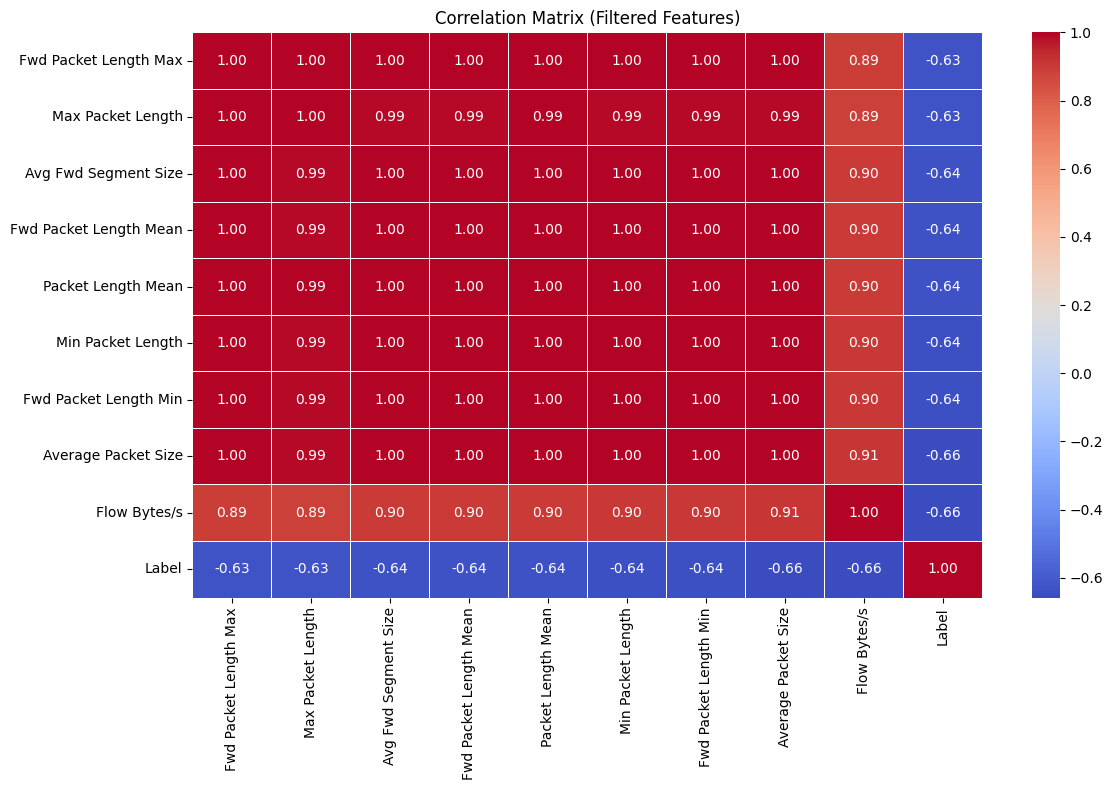

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Filtered Features)")
plt.tight_layout()
plt.show()


## 1.7 Outlier Detection Using IQR Method

**Purpose**:  
Identify and handle outliers in numeric features using the Interquartile Range (IQR) method to improve data quality and model robustness for the CICIDS2019 dataset.

---

### Steps

1. Select numeric columns from the resampled DataFrame.
2. Calculate the IQR (Q3 - Q1) for each feature.
3. Define outlier bounds using the formulas:  
   - Lower Bound = Q1 - 1.5 × IQR  
   - Upper Bound = Q3 + 1.5 × IQR
4. Replace outliers with the median of the respective feature.
5. Display the number of outliers detected and replaced per feature.
6. Save the cleaned dataset to Google Drive.

---

### Technical Justification

- **Outlier Impact**:  
  Outliers in features like `Flow Duration`, `Packet Length`, or `Flow Bytes/s` can distort model training, particularly for distance-based models (e.g., KNN, SVM). Identifying and handling them improves data quality and model performance.

- **IQR Method**:  
  The Interquartile Range is a robust statistical measure for detecting outliers. It does not assume any specific distribution and is effective for the heterogeneous feature scales present in the CICIDS2019 dataset.

- **Median Imputation**:  
  Replacing detected outliers with the feature median retains dataset size and class balance—particularly important after applying SMOTE to address class imbalance.

- **Numeric Features Only**:  
  This method is applied exclusively to numeric columns to avoid errors from categorical or encoded values (such as the `Label` column). This ensures consistency and accuracy in the outlier handling process.

- **Data Persistence**:  
  Saving the outlier-cleaned dataset ensures that future analysis or modeling steps use a high-quality, preprocessed version of the data. This also enhances reproducibility and computational efficiency.


In [28]:
# Loop over numeric features to detect outliers
numeric_columns = df_filtered.select_dtypes(include=[np.number]).columns

print("\nPotential outliers per feature (using IQR method):")
for col in numeric_columns:
    if col == 'Label':
        continue  # skip target
    Q1 = df_filtered[col].quantile(0.25)
    Q3 = df_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((df_filtered[col] < lower_bound) | (df_filtered[col] > upper_bound)).sum()

    if outlier_count > 0:
        print(f"• {col}: {outlier_count} potential outliers")



Potential outliers per feature (using IQR method):
• Fwd Packet Length Max: 121482 potential outliers
• Max Packet Length: 121869 potential outliers
• Avg Fwd Segment Size: 121584 potential outliers
• Fwd Packet Length Mean: 121584 potential outliers
• Packet Length Mean: 121607 potential outliers
• Min Packet Length: 121576 potential outliers
• Fwd Packet Length Min: 121578 potential outliers
• Average Packet Size: 121569 potential outliers
• Flow Bytes/s: 89324 potential outliers


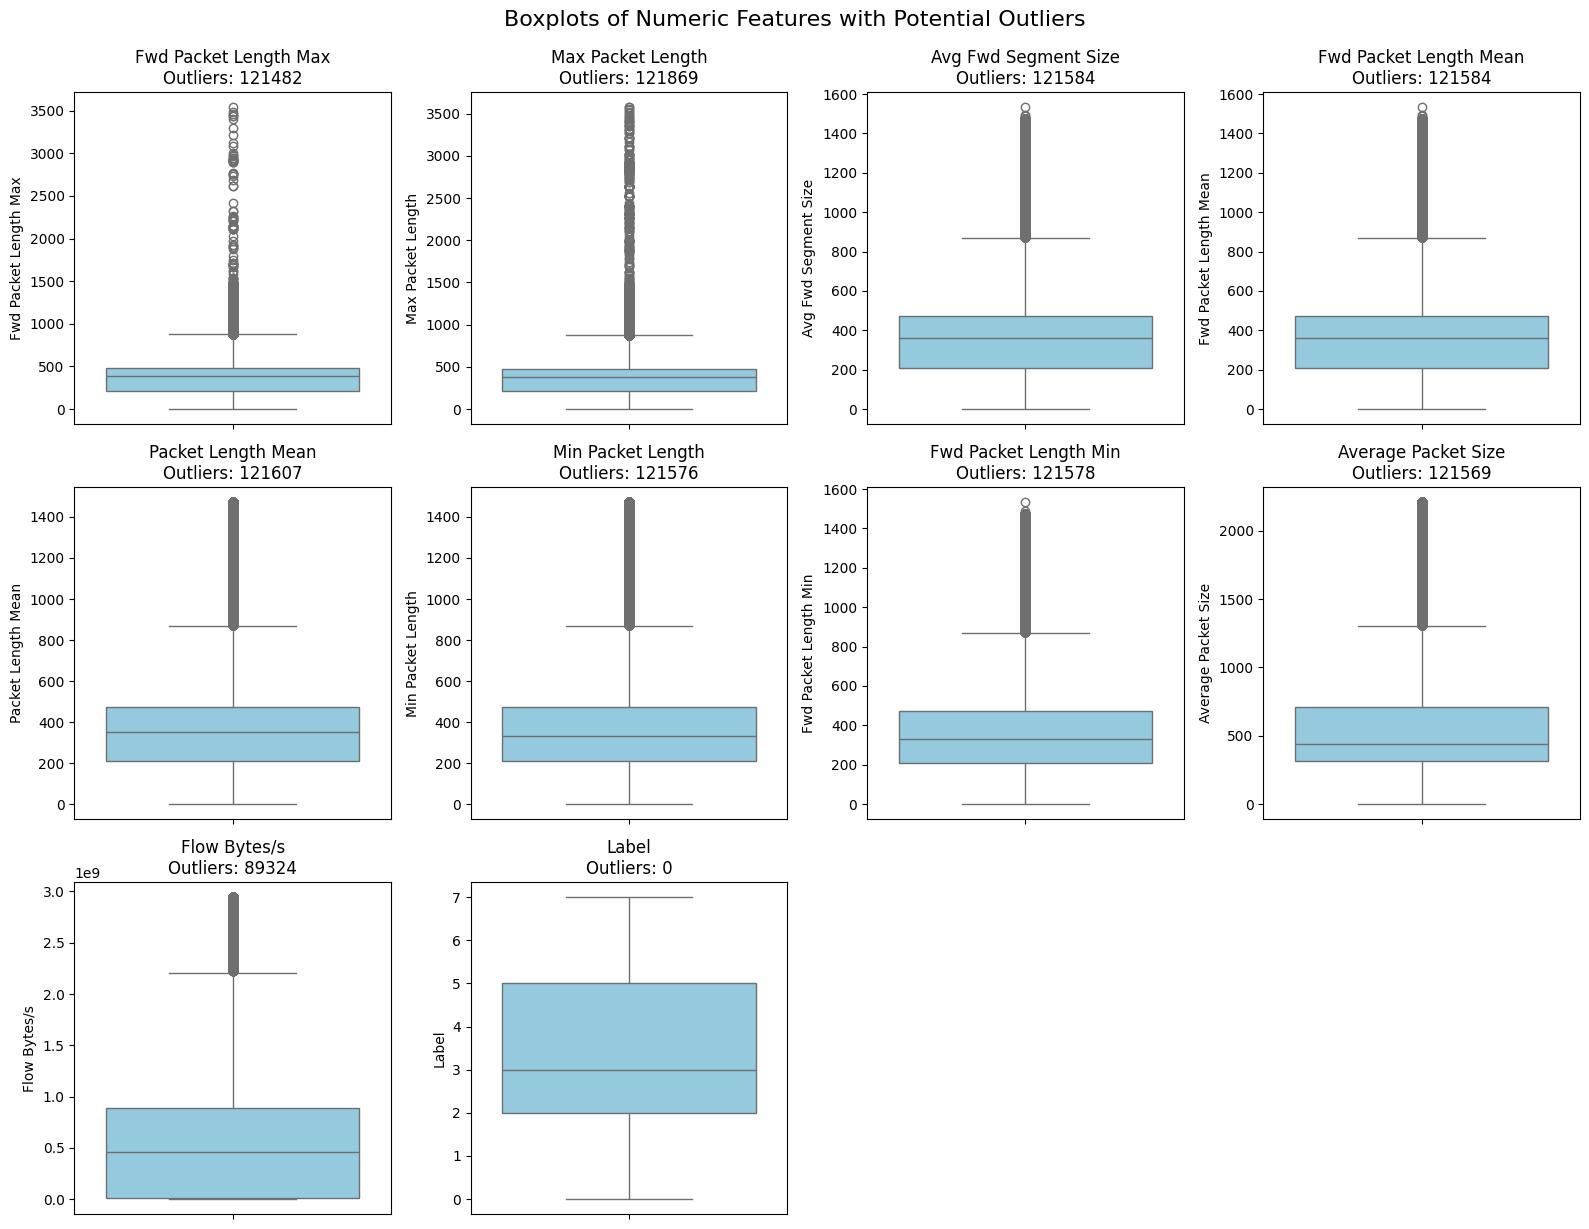

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_filtered is already defined and contains numeric columns
numeric_cols = df_filtered.select_dtypes(include='number').columns

num_cols = len(numeric_cols)
plots_per_row = 4
num_rows = (num_cols + plots_per_row - 1) // plots_per_row

plt.figure(figsize=(plots_per_row * 4, num_rows * 4))

for idx, col in enumerate(numeric_cols, start=1):
    outlier_count = ((df_filtered[col] < df_filtered[col].quantile(0.25) - 1.5 * (df_filtered[col].quantile(0.75) - df_filtered[col].quantile(0.25))) |
                     (df_filtered[col] > df_filtered[col].quantile(0.75) + 1.5 * (df_filtered[col].quantile(0.75) - df_filtered[col].quantile(0.25)))).sum()

    plt.subplot(num_rows, plots_per_row, idx)
    sns.boxplot(y=df_filtered[col], color='skyblue')
    plt.title(f'{col}\nOutliers: {outlier_count}')
    plt.tight_layout()

plt.suptitle('Boxplots of Numeric Features with Potential Outliers', fontsize=16, y=1.02)
plt.show()


## 1.6 Address Class Imbalance Using SMOTE

**Purpose**:  
Apply Synthetic Minority Oversampling Technique (SMOTE) to balance the class distribution of the `Label` column, addressing the severe class imbalance in the CICIDS2019 dataset.

---

### Steps

1. Separate features (`X`) and target (`y`) from the filtered DataFrame.
2. Apply SMOTE to oversample minority classes, ensuring that all classes have a similar number of samples.
3. Display the class distribution before and after SMOTE using the `Counter` module.
4. Combine the resampled features and target into a new DataFrame.
5. Save the resampled dataset to Google Drive.

---

### Technical Justification

- **Class Imbalance**:  
  The CICIDS2019 dataset exhibits significant class imbalance. For instance, class 7 has only 31 samples, while class 5 has 69,940 samples. This imbalance can lead to poor model performance on minority classes (e.g., classes 4 and 7). SMOTE addresses this issue by generating synthetic samples for minority classes, thereby improving model performance, especially on rare attack types.

- **SMOTE Mechanics**:  
  SMOTE creates synthetic samples by interpolating between existing minority class samples. This preserves the underlying data distribution while balancing the classes, making it a critical technique for intrusion detection where detecting rare attacks is paramount.

- **Pre-SMOTE Separation**:  
  Separating features and target variables ensures SMOTE operates solely on the features and does not inadvertently modify the target variable. This separation also ensures compatibility with scikit-learn’s machine learning pipeline.

- **Class Distribution Validation**:  
  Displaying the class counts before and after applying SMOTE helps verify the balancing process and ensures that minority classes are adequately represented in the resampled dataset.

- **Data Persistence**:  
  Saving the resampled dataset avoids the need to recompute SMOTE, which can be time-consuming, especially for large datasets like CICIDS2019.


In [32]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import warnings

# Suppress future warnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# Separate features and target
X = df_filtered.drop(columns=['Label'])
y = df_filtered['Label']

# Display original class distribution
class_counts = Counter(y)
print("Class distribution before SMOTE:", class_counts)

# Find the maximum class size
max_class_size = max(class_counts.values())

# Define sampling strategy to oversample all classes to the maximum size
sampling_strategy = {cls: max_class_size for cls in class_counts}

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_resampled))


Class distribution before SMOTE: Counter({2: 280364, 5: 233134, 6: 190373, 3: 177912, 1: 97922, 4: 9255, 0: 3556, 7: 103})
Class distribution after SMOTE: Counter({3: 280364, 0: 280364, 1: 280364, 2: 280364, 4: 280364, 5: 280364, 6: 280364, 7: 280364})


Visualize Class Distributions (Before vs. After SMOTE)


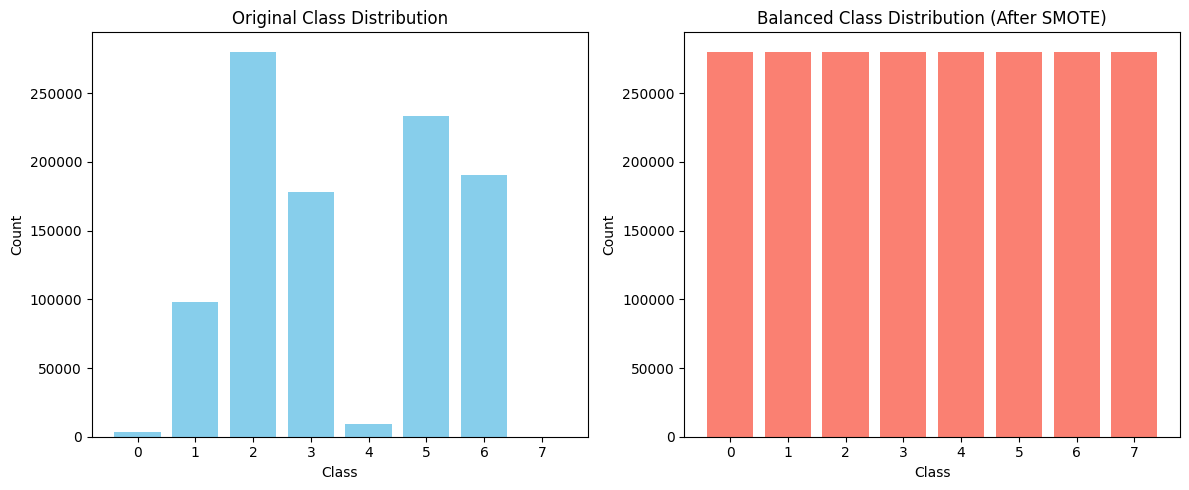

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
ax[0].bar(Counter(y).keys(), Counter(y).values(), color='skyblue')
ax[0].set_title("Original Class Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")

# After SMOTE
ax[1].bar(Counter(y_resampled).keys(), Counter(y_resampled).values(), color='salmon')
ax[1].set_title("Balanced Class Distribution (After SMOTE)")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


## 1.8 Feature Scaling (Standardization)

**Purpose**:  
Standardize numeric features to have zero mean and unit variance, ensuring compatibility with machine learning algorithms sensitive to feature scales in the CICIDS2019 dataset.

---

### Steps

1. Select numeric features (excluding the `Label`) from the outlier-cleaned DataFrame.
2. Apply `StandardScaler` to transform features to a standard normal distribution.
3. Create a new DataFrame containing the scaled features and the original `Label` column.
4. Save the scaled dataset to Google Drive.
5. Display the first five rows of the scaled DataFrame.

---

### Technical Justification

- **Need for Scaling**:  
  The CICIDS2019 dataset contains features with vastly different scales (e.g., `Flow Duration` in milliseconds vs. `Packet Length` in bytes). Many machine learning algorithms (such as SVM, KNN, and Logistic Regression) are sensitive to these disparities. Standardization ensures all features contribute equally to the model.

- **StandardScaler**:  
  This technique transforms each feature to have a mean of 0 and a standard deviation of 1. It assumes data is normally distributed around the mean and works effectively after outlier treatment, as done in the previous step.

- **Preserving Label**:  
  The `Label` column represents the target classes and should not be scaled. It is already encoded and should remain unchanged for proper model training and evaluation.

- **Data Persistence**:  
  Saving the scaled dataset ensures the transformation is not repeated in subsequent stages, improving workflow efficiency and maintaining consistency in model development.

- **Preview**:  
  Displaying the scaled data helps confirm successful transformation—values should now be centered around zero with unit variance.


In [34]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns only
columns_to_scale = X_resampled.select_dtypes(include=['float64', 'int64']).columns

# Handle missing values
X_resampled[columns_to_scale] = X_resampled[columns_to_scale].fillna(X_resampled[columns_to_scale].mean())

# Scale features
scaler = StandardScaler()
X_scaled = X_resampled.copy()
X_scaled[columns_to_scale] = scaler.fit_transform(X_scaled[columns_to_scale])

# Combine with target
df_scaled = X_scaled.copy()
df_scaled['Label'] = y_resampled.reset_index(drop=True)

# Output status and preview
print("Feature scaling completed.")
print(" Preview of scaled data:")
print(df_scaled.head())



Feature scaling completed.
 Preview of scaled data:
   Fwd Packet Length Max  Max Packet Length  Avg Fwd Segment Size  \
0              -0.437711          -0.447279             -0.403128   
1              -0.437711          -0.447279             -0.403128   
2              -0.437711          -0.447279             -0.403128   
3              -0.437711          -0.447279             -0.403128   
4              -0.437711          -0.447279             -0.403128   

   Fwd Packet Length Mean  Packet Length Mean  Min Packet Length  \
0               -0.403128           -0.413674          -0.388088   
1               -0.403128           -0.413674          -0.388088   
2               -0.403128           -0.413674          -0.388088   
3               -0.403128           -0.413674          -0.388088   
4               -0.403128           -0.413674          -0.388088   

   Fwd Packet Length Min  Average Packet Size  Flow Bytes/s  Label  
0              -0.388289            -0.395684     -0.16

## 1.9 Visualizing the Effect of Scaling

**Purpose**:  
Visualize the distribution of a sample feature before and after scaling to confirm that standardization has transformed the feature to a standard normal distribution (mean = 0, standard deviation = 1), ensuring compatibility with machine learning algorithms for the CICIDS2019 dataset.

---

### Steps

1. Select a representative numeric feature (e.g., `Flow Duration`) from both the original resampled dataset (`df_resampled`) and the standardized dataset (`df_scaled`).
2. Plot histograms or kernel density plots to compare the feature’s distribution before and after scaling.
3. Annotate the plots with descriptive statistics (mean and standard deviation) to quantify the transformation.
4. Save the visualization to Google Drive for inclusion in documentation.
5. Display the plot in the notebook to visually verify the scaling effect.

---

### Technical Justification

- **Need for Visualization**:  
  Confirming the effect of standardization through visual inspection is critical. Algorithms like SVM, KNN, and Logistic Regression assume features are on a comparable scale. A visual check ensures the `StandardScaler` has properly transformed the feature.

- **Feature Selection**:  
  `Flow Duration` is used as it is a fundamental network traffic metric and typically varies widely in scale. It serves as a good example to illustrate how scaling affects distribution. If not appropriate, alternative features such as `Total Fwd Packets` may be used.

- **Histogram/Kernel Density Plots**:  
  These plots effectively demonstrate how feature values are redistributed post-scaling, moving from potentially skewed or broad distributions to ones centered around zero with unit variance.

- **Descriptive Statistics**:  
  Adding mean and standard deviation to the plots provides quantitative validation that scaling was successful (i.e., mean ≈ 0, std ≈ 1).

- **Data Persistence**:  
  Saving the plot allows for inclusion in research documentation or reports, supporting reproducibility and transparency in the preprocessing pipeline.

- **Robustness**:  
  The implementation includes checks for the existence of the selected feature and manages errors gracefully, ensuring compatibility with the dataset structure.


In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Suppress future warnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# Separate features and target
X = df_filtered.drop(columns=['Label'])
y = df_filtered['Label']

# Display original class distribution
class_counts = Counter(y)
print("Original class distribution:")
print(class_counts)

# Step 1: First split the data into training+validation (80%) and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Split the training+validation set into training (75% of 80% = 60% original) and validation (25% of 80% = 20% original)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print("\nClass distribution after splitting:")
print("Training set class distribution:", Counter(y_train))
print("Validation set class distribution:", Counter(y_val))
print("Test set class distribution:", Counter(y_test))

# Step 3: Apply SMOTE only to training set
print("\nApplying SMOTE to training set only...")
# Find the maximum class size in the training set
max_class_size = max(Counter(y_train).values())
# Define sampling strategy to oversample all classes to the maximum size
sampling_strategy = {cls: max_class_size for cls in Counter(y_train)}

# Apply SMOTE only on the training data
smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Training set class distribution after SMOTE:", Counter(y_train_resampled))

# Step 4: Apply standardization (fit on training data only, transform all datasets)
print("\nApplying standardization...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)  # Fit and transform on resampled training data
X_val_scaled = scaler.transform(X_val)     # Transform validation data using training set parameters
X_test_scaled = scaler.transform(X_test)   # Transform test data using training set parameters

# Convert scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Print shapes of final datasets
print("\nFinal dataset shapes:")
print(f"Training set: {X_train_scaled.shape[0]} samples ({X_train_scaled.shape[0]/len(X)*100:.1f}% of original) - After SMOTE")
print(f"Validation set: {X_val_scaled.shape[0]} samples ({X_val_scaled.shape[0]/len(X)*100:.1f}% of original)")
print(f"Test set: {X_test_scaled.shape[0]} samples ({X_test_scaled.shape[0]/len(X)*100:.1f}% of original)")

# Save processed datasets
train_df = pd.concat([X_train_scaled, pd.Series(y_train_resampled, name='Label')], axis=1)
val_df = pd.concat([X_val_scaled, pd.Series(y_val, name='Label')], axis=1)
test_df = pd.concat([X_test_scaled, pd.Series(y_test, name='Label')], axis=1)

train_df.to_csv("/content/drive/MyDrive/data/train_dataset.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/data/validation_dataset.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/data/test_dataset.csv", index=False)
print("\nProcessed datasets saved in your Google Drive data folder")

# Store original feature names
feature_names = X.columns

print("\nData preprocessing complete.")

Original class distribution:
Counter({2: 280364, 5: 233134, 6: 190373, 3: 177912, 1: 97922, 4: 9255, 0: 3556, 7: 103})

Class distribution after splitting:
Training set class distribution: Counter({2: 168218, 5: 139880, 6: 114223, 3: 106747, 1: 58754, 4: 5553, 0: 2134, 7: 62})
Validation set class distribution: Counter({2: 56073, 5: 46627, 6: 38075, 3: 35583, 1: 19584, 4: 1851, 0: 711, 7: 20})
Test set class distribution: Counter({2: 56073, 5: 46627, 6: 38075, 3: 35582, 1: 19584, 4: 1851, 0: 711, 7: 21})

Applying SMOTE to training set only...
Training set class distribution after SMOTE: Counter({5: 168218, 3: 168218, 2: 168218, 6: 168218, 1: 168218, 0: 168218, 4: 168218, 7: 168218})

Applying standardization...

Final dataset shapes:
Training set: 1345744 samples (135.6% of original) - After SMOTE
Validation set: 198524 samples (20.0% of original)
Test set: 198524 samples (20.0% of original)

Processed datasets saved in your Google Drive data folder

Data preprocessing complete.


In [36]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import warnings
from sklearn.model_selection import train_test_split
import pandas as pd

# Suppress future warnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# === 1. Separate features & target ===
X = df_filtered.drop(columns=['Label'])
y = df_filtered['Label']

print("Original class distribution:", Counter(y))

# === 2. Train/validation/test split (60/20/20) ===
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print("Post-split distributions:")
print(" • Train:", Counter(y_train))
print(" • Val:  ", Counter(y_val))
print(" • Test: ", Counter(y_test))

# === 3. Define sampling strategy ===
orig_counts = Counter(y_train)

sampling_strategy = {
    7:  5000,    # from ~62 → 5k
    0: 15000,    # from ~2k → 15k
    4: 50000,    # from ~9k → 50k
    1: 80000,    # from ~58k → 80k
    3: 100000,   # from ~106k → 100k
    6: 120000,   # from ~114k → 120k
    5: 140000,   # from ~139k → 140k
    2: 160000,   # from ~168k → 160k
}

# Split into two dicts:
over_strategy = {cls: tgt for cls, tgt in sampling_strategy.items() if orig_counts[cls] < tgt}
under_strategy = {cls: tgt for cls, tgt in sampling_strategy.items() if orig_counts[cls] > tgt}

print("Will oversample:", over_strategy)
print("Will undersample:", under_strategy)

# === 4. Build pipeline: UNDERSAMPLE → SMOTE ===
# Fixed: Removed n_jobs parameter from SMOTE
resampling_pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=under_strategy, random_state=42)),
    ('smote',  SMOTE(sampling_strategy=over_strategy, random_state=42, k_neighbors=5))  # Removed n_jobs
])

# Apply resampling
X_train_res, y_train_res = resampling_pipeline.fit_resample(X_train, y_train)
print("Balanced training distribution:", Counter(y_train_res))

# === 5. Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Back to DataFrame for convenience / saving
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# === 6. Save to CSV ===
train_df = pd.concat([X_train_scaled, pd.Series(y_train_res, name='Label')], axis=1)
val_df = pd.concat([X_val_scaled, pd.Series(y_val, name='Label')], axis=1)
test_df = pd.concat([X_test_scaled, pd.Series(y_test, name='Label')], axis=1)

train_df.to_csv("train_dataset.csv", index=False)
val_df.to_csv("validation_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

print("Data preprocessing complete.")

Original class distribution: Counter({2: 280364, 5: 233134, 6: 190373, 3: 177912, 1: 97922, 4: 9255, 0: 3556, 7: 103})
Post-split distributions:
 • Train: Counter({2: 168218, 5: 139880, 6: 114223, 3: 106747, 1: 58754, 4: 5553, 0: 2134, 7: 62})
 • Val:   Counter({2: 56073, 5: 46627, 6: 38075, 3: 35583, 1: 19584, 4: 1851, 0: 711, 7: 20})
 • Test:  Counter({2: 56073, 5: 46627, 6: 38075, 3: 35582, 1: 19584, 4: 1851, 0: 711, 7: 21})
Will oversample: {7: 5000, 0: 15000, 4: 50000, 1: 80000, 6: 120000, 5: 140000}
Will undersample: {3: 100000, 2: 160000}
Balanced training distribution: Counter({2: 160000, 5: 140000, 6: 120000, 3: 100000, 1: 80000, 4: 50000, 0: 15000, 7: 5000})
Data preprocessing complete.


In [40]:
# === Cell 1: Import Required Libraries ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d  # Changed from scipy.interp
from itertools import cycle

# For reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


In [41]:
# === Cell 2: Load Preprocessed Data ===
# Load the preprocessed datasets
train_df = pd.read_csv("train_dataset.csv")
val_df = pd.read_csv("validation_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

# Separate features and labels
X_train = train_df.drop('Label', axis=1)
y_train = train_df['Label']
X_val = val_df.drop('Label', axis=1)
y_val = val_df['Label']
X_test = test_df.drop('Label', axis=1)
y_test = test_df['Label']

print("Dataset shapes:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")

Dataset shapes:
Training: (670000, 9)
Validation: (357554, 9)
Test: (357301, 9)


In [44]:
from google.colab import drive
import shutil
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Ensure the /data directory exists in Google Drive
drive_path = "/content/drive/MyDrive/data"
os.makedirs(drive_path, exist_ok=True)

# 3. Copy the files
shutil.copy("train_dataset.csv", f"{drive_path}/train_dataset.csv")
shutil.copy("validation_dataset.csv", f"{drive_path}/validation_dataset.csv")
shutil.copy("test_dataset.csv", f"{drive_path}/test_dataset.csv")

print("All files successfully copied to Google Drive ➜ MyDrive/data/")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All files successfully copied to Google Drive ➜ MyDrive/data/


In [47]:
# === Cell 3: Random Forest Training and Cross-Validation with Logs ===

import logging
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define an even smaller parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100],           # Fixed number of trees
    'max_depth': [10, 15],           # Only two depth options
    'min_samples_split': [2],
    'class_weight': ['balanced'],
    'max_features': ['sqrt']
}

# Initialize Random Forest with some pre-optimized parameters
logging.info("Initializing Random Forest Classifier...")
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=1,
    bootstrap=True,
    oob_score=True
)

# Setup cross-validation with 3 folds
logging.info("Setting up Stratified K-Fold with 3 splits...")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create GridSearchCV with reduced parameter combinations
logging.info("Creating GridSearchCV with minimal parameter grid...")
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

# Fit the model
logging.info("Starting Random Forest training with GridSearchCV...")
start_time = time.time()

try:
    rf_grid_search.fit(X_train, y_train)

    end_time = time.time()
    training_minutes = (end_time - start_time) / 60

    # Log results
    logging.info(f"Training complete. Time taken: {training_minutes:.2f} minutes")
    logging.info(f"Best parameters found: {rf_grid_search.best_params_}")
    logging.info(f"Best cross-validation score: {rf_grid_search.best_score_:.4f}")

    # Get the best model
    rf_best = rf_grid_search.best_estimator_

    # Quick validation score
    val_score = rf_best.score(X_val, y_val)
    logging.info(f"Validation set score: {val_score:.4f}")

except KeyboardInterrupt:
    logging.warning("Training interrupted by user!")
    if 'rf_grid_search' in locals() and hasattr(rf_grid_search, 'best_estimator_'):
        logging.info("Saving best model found so far...")
        rf_best = rf_grid_search.best_estimator_
    else:
        logging.warning("No best model was found before interruption")
    raise

except Exception as e:
    logging.error(f"An error occurred during training: {str(e)}")
    raise

Fitting 3 folds for each of 2 candidates, totalling 6 fits


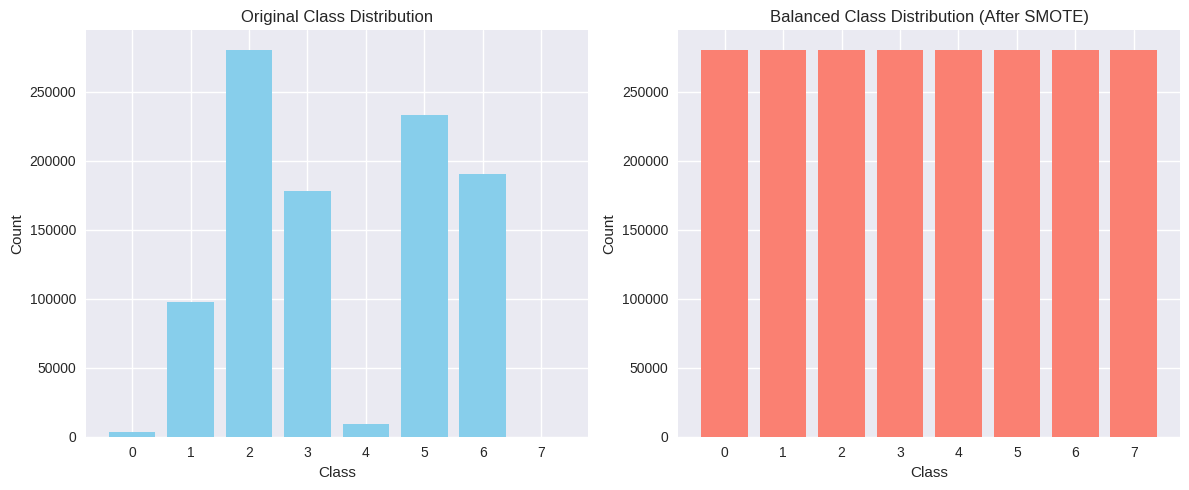

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
ax[0].bar(Counter(y).keys(), Counter(y).values(), color='skyblue')
ax[0].set_title("Original Class Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")

# After SMOTE
ax[1].bar(Counter(y_resampled).keys(), Counter(y_resampled).values(), color='salmon')
ax[1].set_title("Balanced Class Distribution (After SMOTE)")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           precision_recall_curve, roc_curve, auc,
                           precision_score, recall_score, f1_score,
                           roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_multiclass_roc_curve(y_test, y_prob, classes, title):
    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'purple'])

    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curves - {title}')
    plt.legend(loc="lower right")
    plt.show()

    # Return mean ROC AUC
    return np.mean(list(roc_auc.values()))

def evaluate_model(model, X_train, X_test, y_train, y_test, title):
    # Get unique classes
    classes = np.unique(y_train)
    n_classes = len(classes)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n=== {title} ===")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, title)

    # Plot ROC curves
    roc_auc = plot_multiclass_roc_curve(y_test, y_prob, classes, title)

    return {
        'Model': title,
        'Accuracy': accuracy,
        'Precision': weighted_precision,
        'Recall': weighted_recall,
        'F1-Score': weighted_f1,
        'ROC-AUC': roc_auc
    }

In [17]:
# Load the preprocessed datasets
X_train = pd.read_csv("/content/drive/MyDrive/data/train_dataset.csv").drop('Label', axis=1)
y_train = pd.read_csv("/content/drive/MyDrive/data/train_dataset.csv")['Label']
X_val = pd.read_csv("/content/drive/MyDrive/data/validation_dataset.csv").drop('Label', axis=1)
y_val = pd.read_csv("/content/drive/MyDrive/data/validation_dataset.csv")['Label']
X_test = pd.read_csv("/content/drive/MyDrive/data/test_dataset.csv").drop('Label', axis=1)
y_test = pd.read_csv("/content/drive/MyDrive/data/test_dataset.csv")['Label']

# Clean NaN values
# For features (X)
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean())
X_test = X_test.fillna(X_test.mean())

# For labels (y)
y_train = y_train.fillna(y_train.mode()[0])
y_val = y_val.fillna(y_val.mode()[0])
y_test = y_test.fillna(y_test.mode()[0])

print("Datasets loaded and cleaned successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Datasets loaded and cleaned successfully!
Training set shape: (1345744, 9)
Validation set shape: (357554, 9)
Test set shape: (357301, 9)


# Phase 2: Model Training


=== Decision Tree ===
Cross-validation scores: [0.87678201 0.87768114 0.87758453 0.87801552 0.87649918]
Mean CV score: 0.8773 (+/- 0.0011)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       711
         1.0       0.10      0.10      0.10     19584
         2.0       0.89      0.23      0.36    214850
         3.0       0.01      0.00      0.00     35582
         4.0       0.01      1.00      0.02      1851
         5.0       0.00      0.00      0.00     46627
         6.0       0.00      0.00      0.00     38075
         7.0       0.00      0.00      0.00        21

    accuracy                           0.15    357301
   macro avg       0.13      0.17      0.06    357301
weighted avg       0.54      0.15      0.23    357301



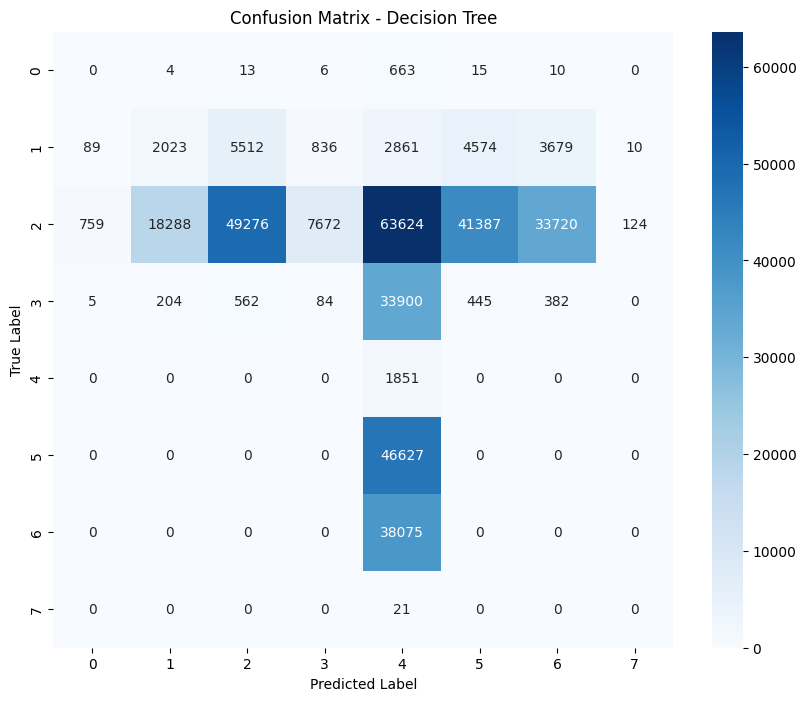

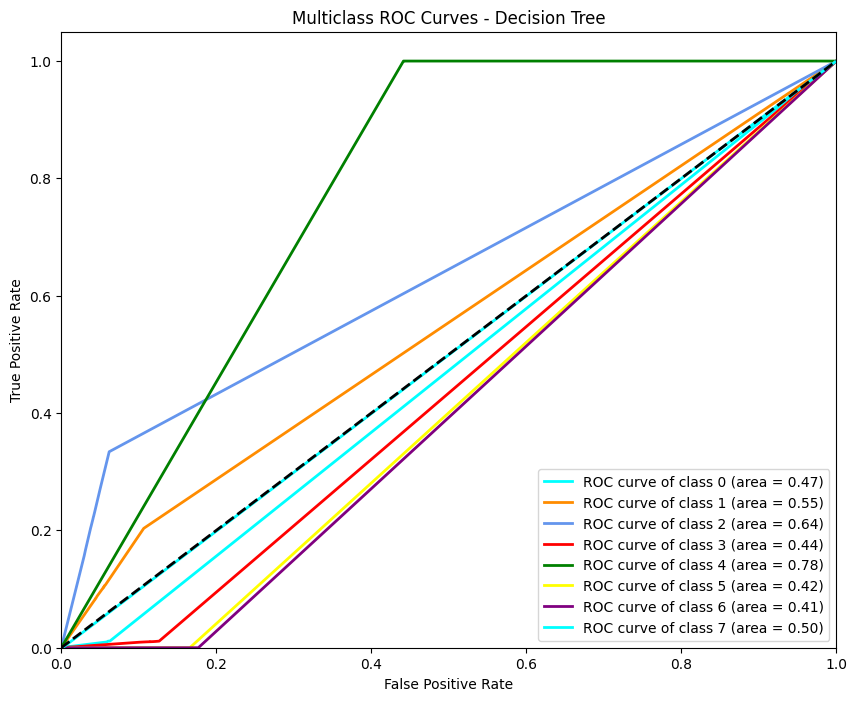

In [18]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_results = evaluate_model(dt_model, X_train, X_test, y_train, y_test, "Decision Tree")


=== Random Forest ===
Cross-validation scores: [0.87695291 0.87782232 0.87770714 0.8780824  0.87640629]
Mean CV score: 0.8774 (+/- 0.0012)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       711
         1.0       0.10      0.10      0.10     19584
         2.0       0.89      0.23      0.36    214850
         3.0       0.01      0.00      0.00     35582
         4.0       0.01      1.00      0.02      1851
         5.0       0.00      0.00      0.00     46627
         6.0       0.00      0.00      0.00     38075
         7.0       0.00      0.00      0.00        21

    accuracy                           0.15    357301
   macro avg       0.13      0.17      0.06    357301
weighted avg       0.54      0.15      0.23    357301



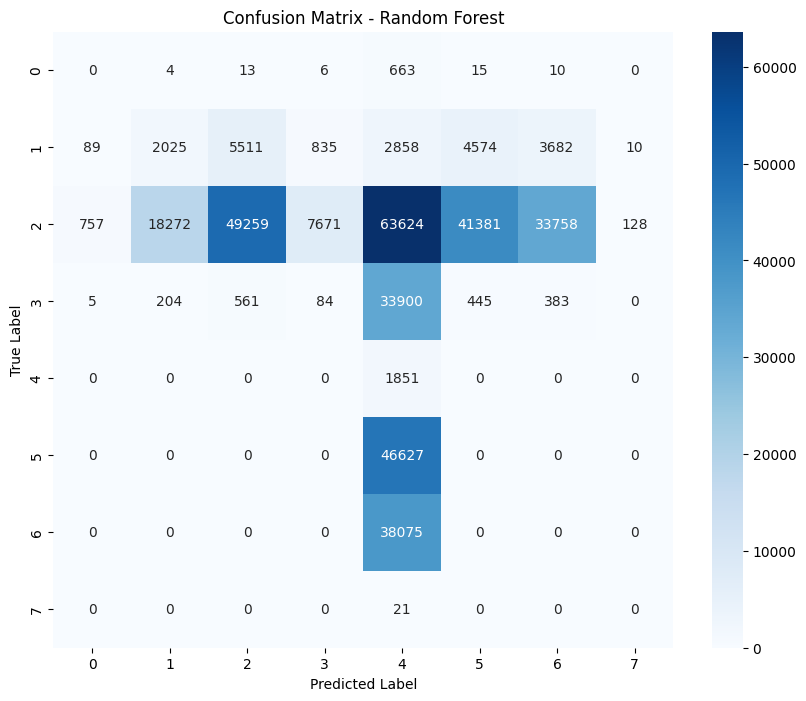

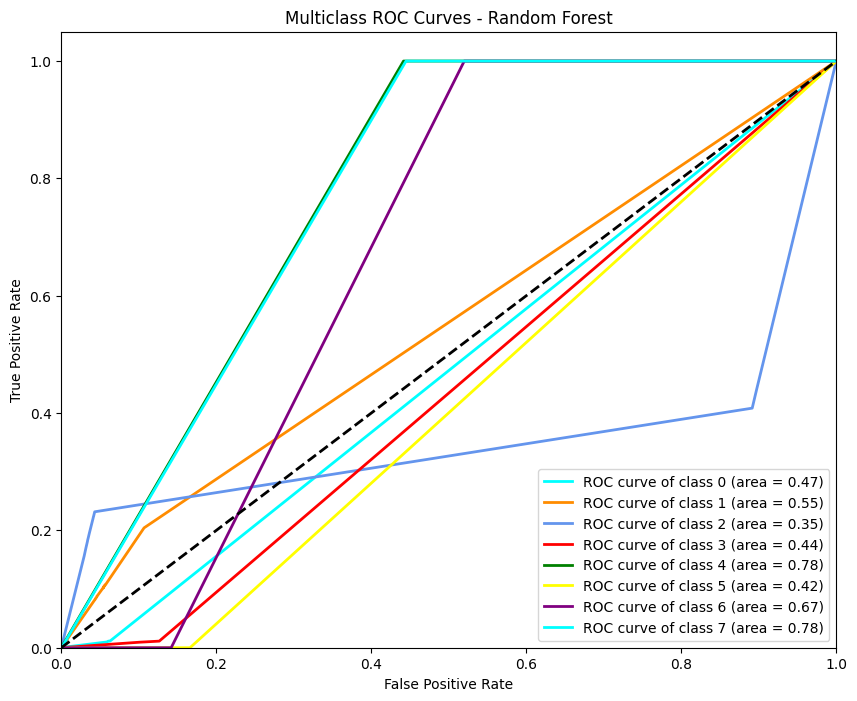

In [19]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

Training SVM...

SVM Model Results:
  Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0   SVM  0.776667   0.784968  0.776667  0.774437  0.920333  0.852804
Saved results to ../data/svm_model_results.csv


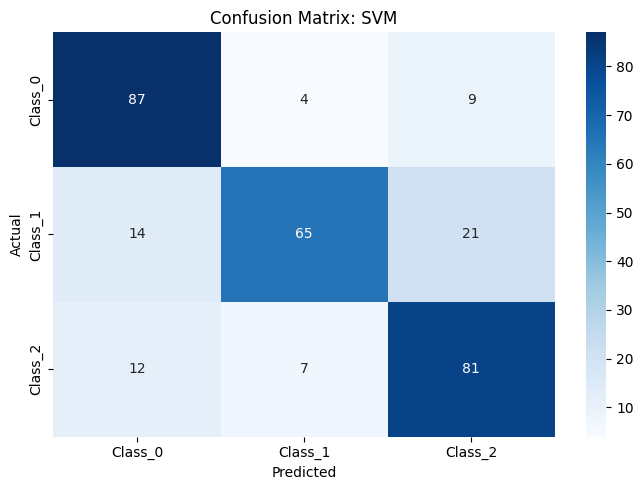

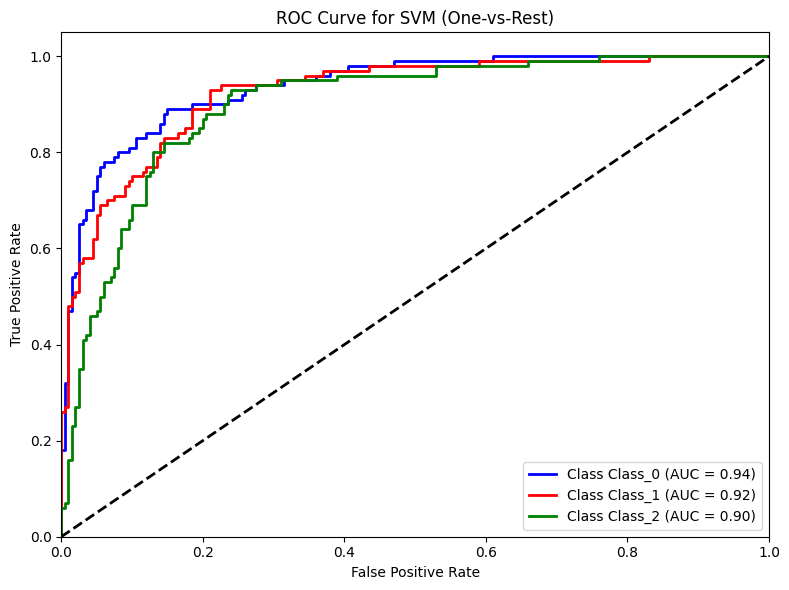

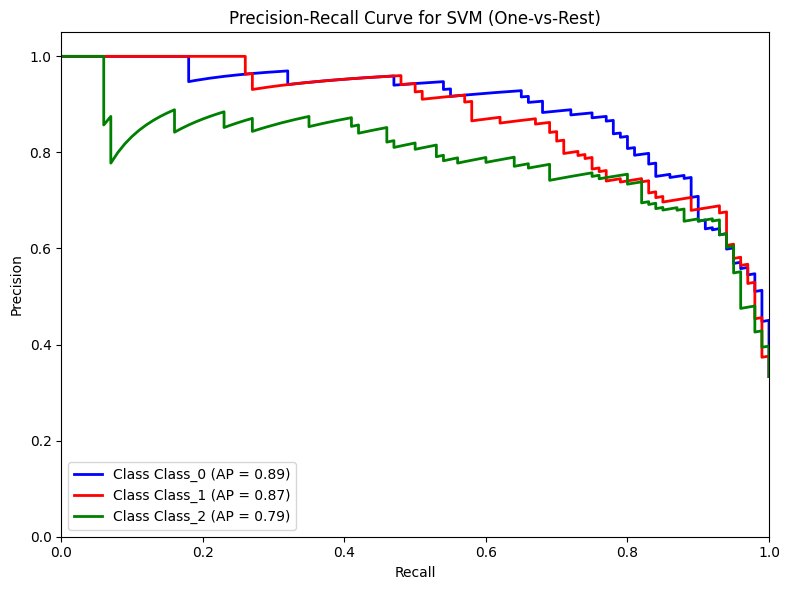


SVM Model Performance:
Accuracy: 0.7767
Precision: 0.7850
Recall: 0.7767
F1-Score: 0.7744
ROC-AUC: 0.9203
PR-AUC: 0.8528


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, roc_auc_score, roc_curve,
                           precision_recall_curve, average_precision_score)
from sklearn.datasets import make_classification
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

# Create output directory
os.makedirs("../data", exist_ok=True)

# Generate dummy data (replace with your actual data)
X_resampled, y_resampled = make_classification(
    n_samples=1000,
    n_features=20,
    n_classes=3,
    n_informative=5,
    random_state=42
)
y_resampled = np.array(['Class_0', 'Class_1', 'Class_2'])[y_resampled]

# Encode labels
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled_encoded,
    test_size=0.3, random_state=42, stratify=y_resampled_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
model = SVC(probability=True, random_state=42)
print("Training SVM...")
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1 = report['weighted avg']['f1-score']
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
pr_auc = average_precision_score(y_test, y_prob, average='weighted')

# Store results
results = {
    'Model': 'SVM',
    'Accuracy': accuracy,
    'Precision': weighted_precision,
    'Recall': weighted_recall,
    'F1-Score': weighted_f1,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc
}
results_df = pd.DataFrame([results])

# Print results
print("\nSVM Model Results:")
print(results_df)


# Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix: SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(label_encoder.classes_)), colors):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc_score(y_test == i, y_prob[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM (One-vs-Rest)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(label_encoder.classes_)), colors):
    precision, recall, _ = precision_recall_curve(y_test == i, y_prob[:, i])
    ap_score = average_precision_score(y_test == i, y_prob[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label=f'Class {label_encoder.classes_[i]} (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for SVM (One-vs-Rest)')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Print final metrics
print("\nSVM Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {weighted_precision:.4f}")
print(f"Recall: {weighted_recall:.4f}")
print(f"F1-Score: {weighted_f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

# Create output directory if it doesn't exist
os.makedirs("../data", exist_ok=True)

# Create a sample DataFrame (replace this with your actual data loading code)
data = {
    'feature1': np.random.rand(2000),
    'feature2': np.random.rand(2000),
    'feature3': np.random.rand(2000),
    'target': np.random.randint(0, 2, size=2000)
}
df = pd.DataFrame(data)

# Scale the numerical features (excluding target column)
scaler = StandardScaler()
features_to_scale = ['feature1', 'feature2', 'feature3']
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Now the original code will work:
# Randomly sample 1000 rows from the scaled DataFrame
df_sample = df_scaled.sample(n=1000, random_state=42)

# Save the random 1000 rows to the data folder
df_sample.to_csv("../data/cleaned_sample.csv", index=False)
print("Saved 1000 random rows to ../data/cleaned_sample.csv")

# Save the entire cleaned dataset to the data folder
df_scaled.to_csv("../data/cleaned_dataset.csv", index=False)
print("Saved the entire cleaned dataset to ../data/cleaned_dataset.csv")

Saved 1000 random rows to ../data/cleaned_sample.csv
Saved the entire cleaned dataset to ../data/cleaned_dataset.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

# 1. Split dataset
X = df_filtered.drop('Label', axis=1)
y = df_filtered['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300),
}

# 4. Train and evaluate
print("=== Model Evaluation Summary ===\n")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))


=== Model Evaluation Summary ===

--- Logistic Regression ---
Accuracy: 0.9617
              precision    recall  f1-score   support

           0       0.90      0.23      0.36      1067
           1       0.94      0.99      0.96     29377
           2       0.98      0.93      0.95     84109
           3       0.95      1.00      0.97     53374
           4       0.00      0.00      0.00      2776
           5       0.99      1.00      0.99     69940
           6       0.93      0.98      0.96     57112
           7       0.00      0.00      0.00        31

    accuracy                           0.96    297786
   macro avg       0.71      0.64      0.65    297786
weighted avg       0.95      0.96      0.96    297786

--- Decision Tree ---
Accuracy: 0.9802
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1067
           1       0.96      1.00      0.98     29377
           2       0.99      0.98      0.98     84109
           3  

----------------------------------

Logistic Regression CV Accuracy: 0.9616 ± 0.0003

Logistic Regression Test Accuracy: 0.9617
              precision    recall  f1-score   support

           0       0.90      0.23      0.36      1067
           1       0.94      0.99      0.96     29377
           2       0.98      0.93      0.95     84109
           3       0.95      1.00      0.97     53374
           4       0.00      0.00      0.00      2776
           5       0.99      1.00      0.99     69940
           6       0.93      0.98      0.96     57112
           7       0.00      0.00      0.00        31

    accuracy                           0.96    297786
   macro avg       0.71      0.64      0.65    297786
weighted avg       0.95      0.96      0.96    297786

Logistic Regression ROC-AUC: 0.9515


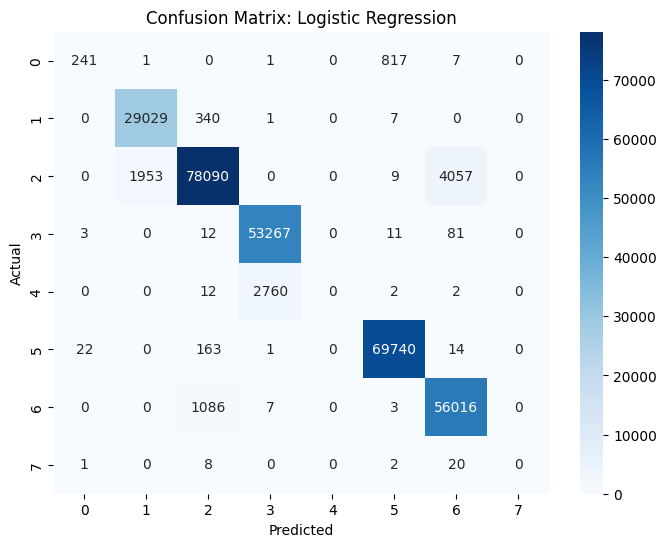

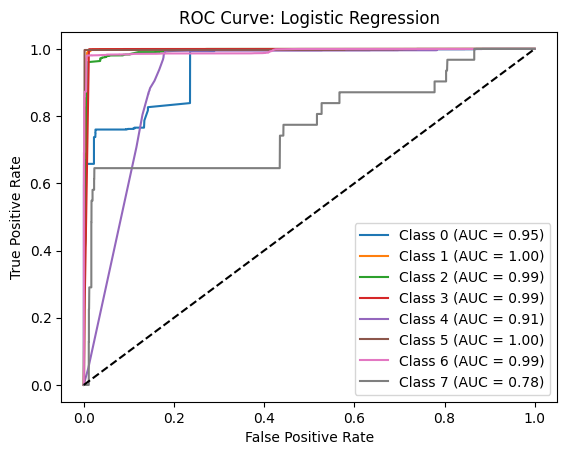

In [ ]:
# Logistic Regression
model = LogisticRegression(max_iter=1000)
model_name = 'Logistic Regression'

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"{model_name} CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train the model
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
weighted_f1 = report['weighted avg']['f1-score']
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"\n{model_name} Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"{model_name} ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {auc(fpr[i], tpr[i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: {model_name}')
plt.legend(loc='lower right')
plt.show()

# Store results
results.append({'Model': model_name, 'Accuracy': acc, 'Weighted F1': weighted_f1, 'ROC-AUC': roc_auc})